In [2]:
import torch
import numpy as np
from tqdm import tqdm 
from time import sleep 
import matplotlib.pyplot as plt


from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

In [3]:
torch.cuda.is_available()

True

In [11]:
train_dataset = datasets.CIFAR10(root = "cifar/", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "cifar/", train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.bn1 = nn.BatchNorm1d(512, affine=True)
        self.bn2 = nn.BatchNorm1d(512, affine=True)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = x.reshape(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def forward_test(self, x):
        x = x.reshape(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(model, optimizer, dataloader, batch:bool):
    for x, y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        if batch == True:
            prediction = model.forward(x)
        else: 
            prediction = model.forward_test(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y.to(torch.long))
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward_test(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [6]:
def batch_norm(model_factory, optimizer_factory, dataloader, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader, True)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
    return losses, accuracies

def baseline_nobatch(model_factory, optimizer_factory, dataloader, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader, False)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
    return losses, accuracies

In [7]:
model = Network()
optimizer  = optim.Adam(model.parameters(), lr= 0.0005, betas= (0.9, 0.95))
batch_losses, batch_accuracies = batch_norm(model, optimizer, train_loader, 25)

100%|██████████| 25/25 [02:06<00:00,  5.05s/it]


In [8]:
model1 = Network()
optimizer1  = optim.Adam(model1.parameters(), lr= 0.005, betas= (0.9, 0.95))
baseline_losses, baseline_accuracies = baseline_nobatch(model1, optimizer1, train_loader, 25)

100%|██████████| 25/25 [02:05<00:00,  5.01s/it]


In [9]:
def plotting_losses(batch, base):
    plt.plot(batch.detach(), 'r', label="With Batch Norm")
    plt.plot(base.detach(), 'k', label="Withouot Batch Norm")
    plt.legend()
    plt.show()
    
def plotting_accuracies(batch, base):
    plt.plot(batch, 'r', label= "With batch norm")
    plt.plot(base, 'k', label= "without batch norm")
    plt.legend()
    plt.show()

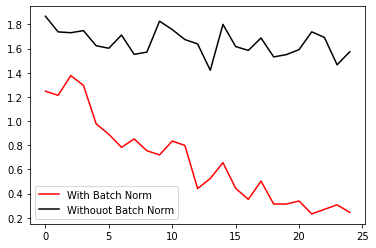

In [10]:
plotting_losses(batch_losses, baseline_losses)

The plot above shows the loss in the training phase for first 5 epochs for the model with and without batch norm. It can be seen that the losses are decresing and a similar trend in the losses can be seen for the full length of training (25 epochs). 

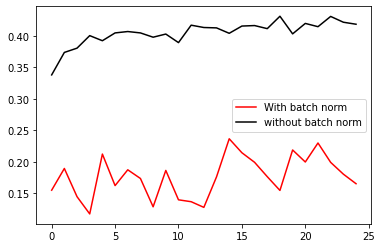

In [11]:
plotting_accuracies(batch_accuracies, baseline_accuracies)

But a different trend can be seen in the aaccuracies. The accuracy over the entire length of training is seen to be considerably lower than the baseline model. This can be due to the fact that the batch norm is applied between the layer and the activation function thus during back propagation this can result in vanishing gradiant. 

In [14]:
baseline_accuracies

tensor([0.3381, 0.3738, 0.3806, 0.4005, 0.3924, 0.4048, 0.4070, 0.4048, 0.3980,
        0.4030, 0.3894, 0.4171, 0.4134, 0.4128, 0.4042, 0.4157, 0.4165, 0.4116,
        0.4313, 0.4033, 0.4199, 0.4147, 0.4310, 0.4218, 0.4186])